In [1]:
import snntorch as snn
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import scipy.io
from pathlib import Path

from modules import SNN, Trainer

### Load spiking data from from https://crcns.org/data-sets/vc/pvc-8

In [2]:
# load input spike data
mat = scipy.io.loadmat(Path('data') / '01.mat') # animal 01
spike_train_all = mat['resp_train'] # spike train of all neurons, neurons x image x trials x milliseconds
print(spike_train_all.shape)

(102, 956, 20, 106)


In [3]:
# get indices of all small natural images
idx_small_nat_images = torch.zeros(spike_train_all.shape[1])
idx_small_nat_images[:539:2] = 1

# get indices of all big natural images
idx_big_nat_images = torch.ones(spike_train_all.shape[1])
idx_big_nat_images[:539:2] = 0
idx_big_nat_images[540:] = 0

# get indices of all gratings
idx_gratings = torch.zeros(spike_train_all.shape[1])
idx_gratings[540:] = 1

In [4]:
# only keep well-centered channels
indcent = mat['INDCENT'].squeeze() # indicates if an stimulus was centered inside the neuron's RF and if the spikes were sorted
spike_train_cent = torch.tensor(spike_train_all[indcent == 1]).float()
spike_train_cent.shape

torch.Size([26, 956, 20, 106])

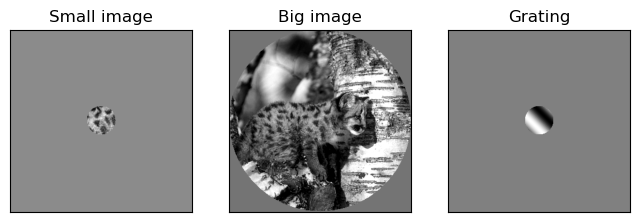

In [5]:
# plot some sample images for each category
images_all = mat['images'].squeeze()
fig, ax = plt.subplots(1, 3, figsize=(8, 8))

fig_titles = ['Small image', 'Big image', 'Grating']
fig_idx = [538, 539, 600]
for i in range(3):
    ax[i].imshow(images_all[fig_idx[i]], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(fig_titles[i])

plt.show()

### Simulate network

In [6]:
# set device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device (CPU or GPU): ', device)

Device (CPU or GPU):  cpu


In [7]:
# layer parameters
n_inputs = spike_train_cent.shape[0] # train on all channels
n_pixels = images_all[0].shape[0] * images_all[0].shape[0]
n_hidden = 256

# hyperparameters
beta = 0.9 
tau_pre = 2
tau_post = 2
n_steps = 200
n_epochs = 10
lr = 1e-2

In [8]:
# set up spike, use spikes of a selected big image, concatenate the trials
spk_in = spike_train_cent[:, 600, :, :].squeeze()
print(spk_in.shape)

target = torch.tensor(images_all[600])

torch.Size([26, 20, 106])


In [9]:
# train network
# TODO: Find better intialization scheme
trainer = Trainer(n_inputs=n_inputs, 
                  n_hidden=n_hidden, 
                  n_pixels=n_pixels, 
                  beta=beta, 
                  n_steps=n_steps, 
                  n_epochs=n_epochs, 
                  device=device, 
                  tau_pre=tau_pre,
                  tau_post=tau_post, 
                  lr=lr)
loss_hist, decoded_image, spk_rec, mem_rec = trainer.train(spk_in, target)

Sequential(
  (lgn): Conv2d(26, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif1): Leaky()
  (v1_simple): Conv2d(16, 4, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (lif2): Leaky()
  (v1_complex): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool): AdaptiveMaxPool2d(output_size=1)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4, out_features=102400, bias=True)
  (lif3): Leaky()
)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [11]:
if not os.path.exists(Path('outputs')):
    os.makedirs(directory)

torch.save(loss_hist, Path('outputs') / 'loss_hist.pt')
torch.save(decoded_image, Path('outputs') / 'decoded_image.pt')
torch.save(spk_rec, Path('outputs') / 'spk_rec.pt')
torch.save(mem_rec, Path('outputs') / 'mem_rec.pt')

### Plotting

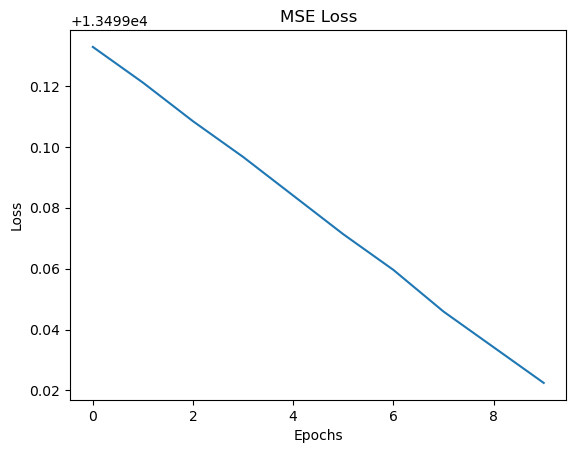

In [12]:
plt.plot(loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss')
plt.show()

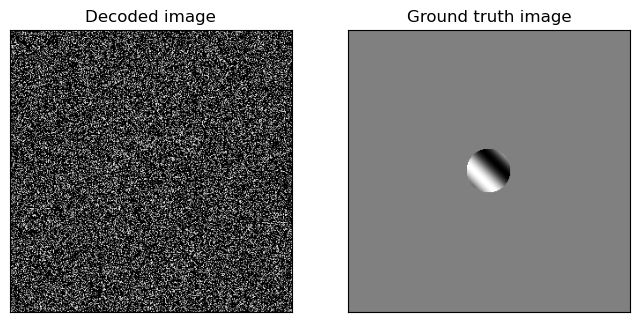

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].imshow(decoded_image.detach().numpy(), cmap='gray')
ax[0].set_title('Decoded image')

ax[1].imshow(target, cmap='gray')
ax[1].set_title('Ground truth image')

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

In [12]:
# fig, ax = plt.subplots(figsize=(10, 5))
# splt.raster(spk_rec.squeeze(), ax, c="black", marker="|")
# ax.set_ylabel("Output Spikes")
# ax.set_xlabel('Time')  
# ax.set_title('Spiking neurons in the last layer')
# plt.show()

In [13]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(mem_rec.detach().numpy().squeeze()[:, :10])
# ax.set_ylabel("Membrane potential")
# ax.set_xlabel('Time')  
# ax.set_title('Membrane potential in the last layer')
# plt.show()